In [1]:
! pip install scanpy python-igraph louvain leidenalg pybiomart

     |████████████████████████████████| 2.0 MB 5.2 MB/s 
     |████████████████████████████████| 3.2 MB 30.7 MB/s 
     |████████████████████████████████| 2.1 MB 34.1 MB/s 
     |████████████████████████████████| 1.4 MB 60.9 MB/s 
     |████████████████████████████████| 80 kB 6.5 MB/s 
     |████████████████████████████████| 127 kB 35.2 MB/s 
     |████████████████████████████████| 1.1 MB 37.8 MB/s 
     |████████████████████████████████| 636 kB 53.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=6f1c08deafc03e7e0f628f058e44ff0f5a0984035c0260d254dab5115f78bc53
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=7f660e76fb3ca2b8bfc4a45dc8b52afded1b3d5ee4a68ffd71db19162fe4fdcc
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/34

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

In [3]:
sc.settings.set_figure_params(dpi=80)
adata = sc.read_h5ad('scanpy_qc_filtered_covid.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 5659 × 18752
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'doublet_info_colors', 'hvg', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'

In [5]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)


# store normalized counts in the raw slot, 
# we will subset adata.X for variable genes, but want to keep all genes matrix as well.
adata.raw = adata

adata

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 5659 × 18752
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'doublet_info_colors', 'hvg', 'neighbors', 'pca', 'sample_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'

Next, we first need to define which features/genes are important in our dataset to distinguish cell types. For this purpose, we need to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.

extracting highly variable genes
    finished (0:00:00)


Trying to set attribute `.uns` of view, copying.


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 610


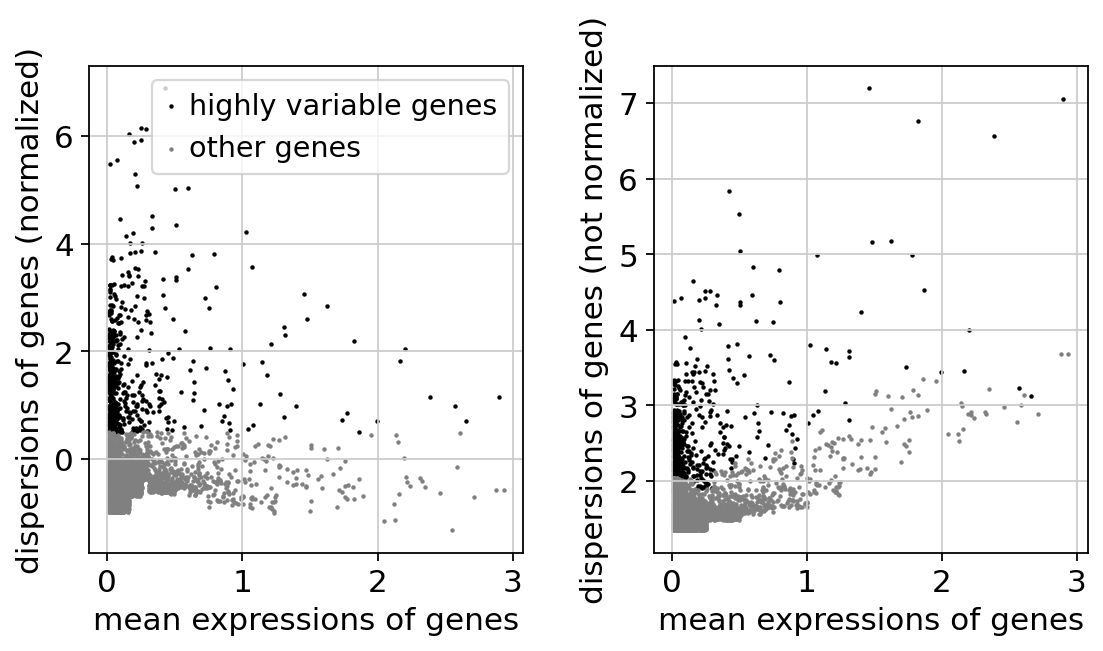

In [7]:
# compute variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))

#plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset
adata = adata[:, adata.var['highly_variable']]

## Z-score transformation

Now that the data is prepared, we now proceed with PCA. Since each gene has a different expression level, it means that genes with higher expression values will naturally have higher variation that will be captured by PCA. This means that we need to somehow give each gene a similar weight when performing PCA (see below). The common practice is to center and scale each gene before performing PCA. This exact scaling is called Z-score normalization it is very useful for PCA, clustering and plotting heatmaps. 

Additionally, we can use regression to remove any unwanted sources of variation from the dataset, such as cell cycle, sequencing depth, percent mitocondria. This is achieved by doing a generalized linear regression using these parameters as covariates in the model. Then the residuals of the model are taken as the "regressed data". Although perhaps not in the best way, batch effect regression can also be done here.

In [8]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:05)


In [9]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


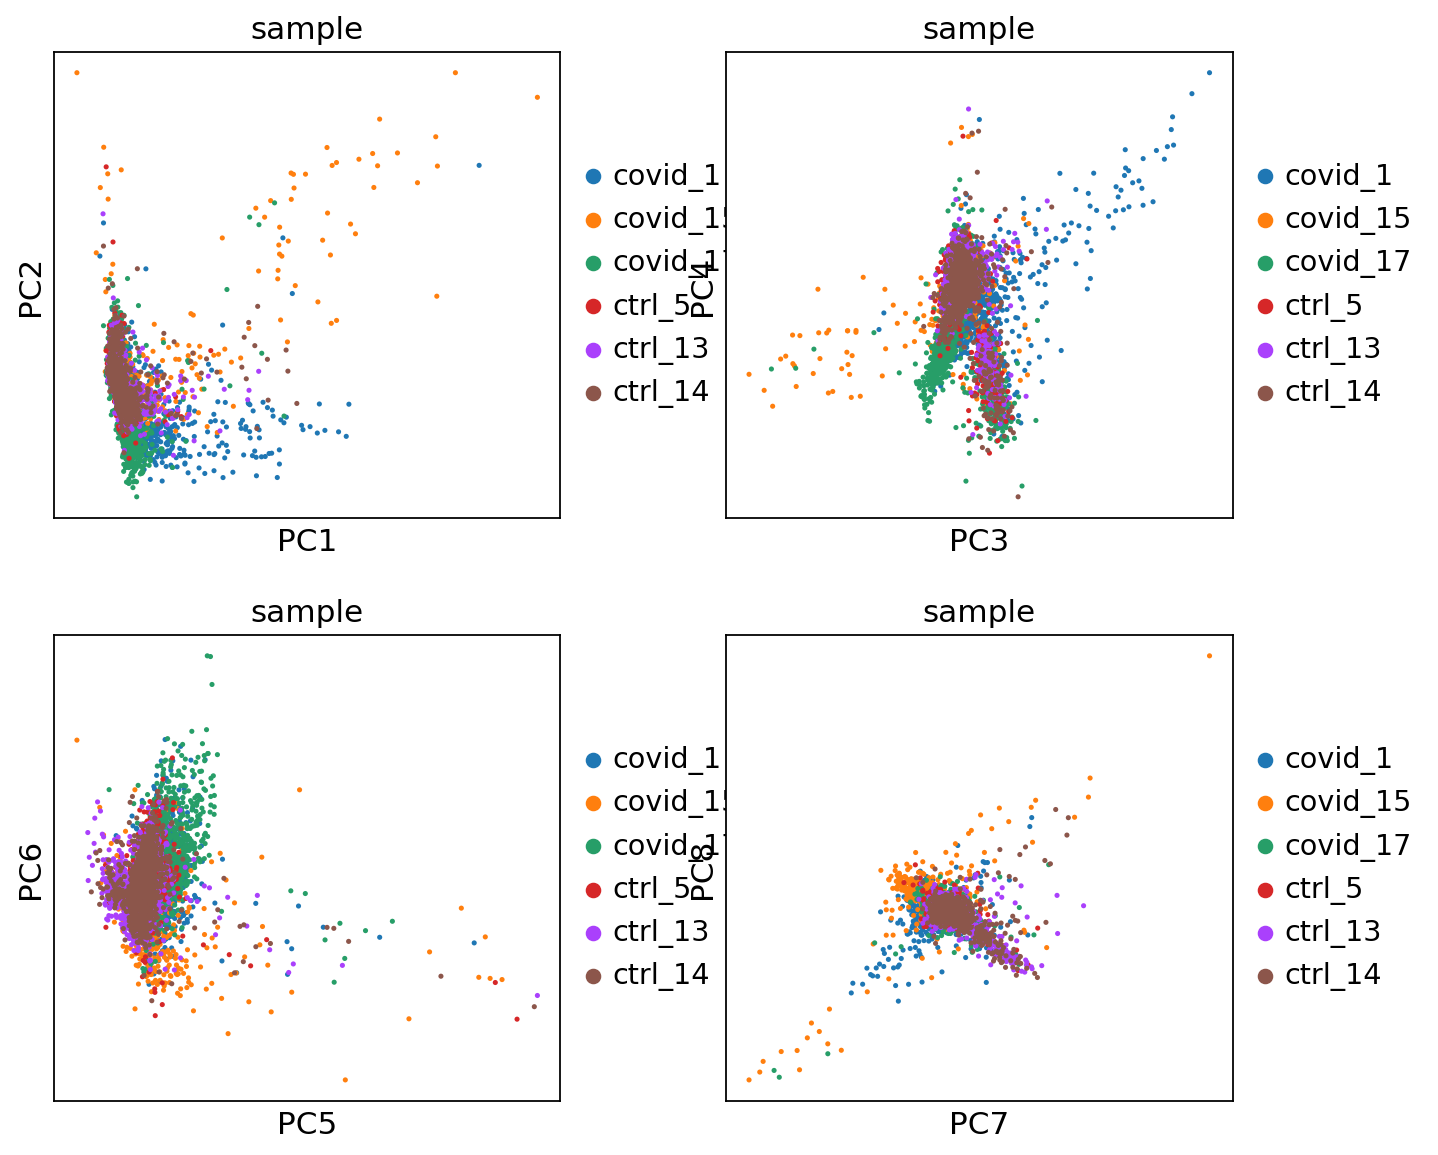

In [10]:
sc.pl.pca(adata, color='sample', components=['1,2', '3,4', '5,6', '7,8'], ncols=2)

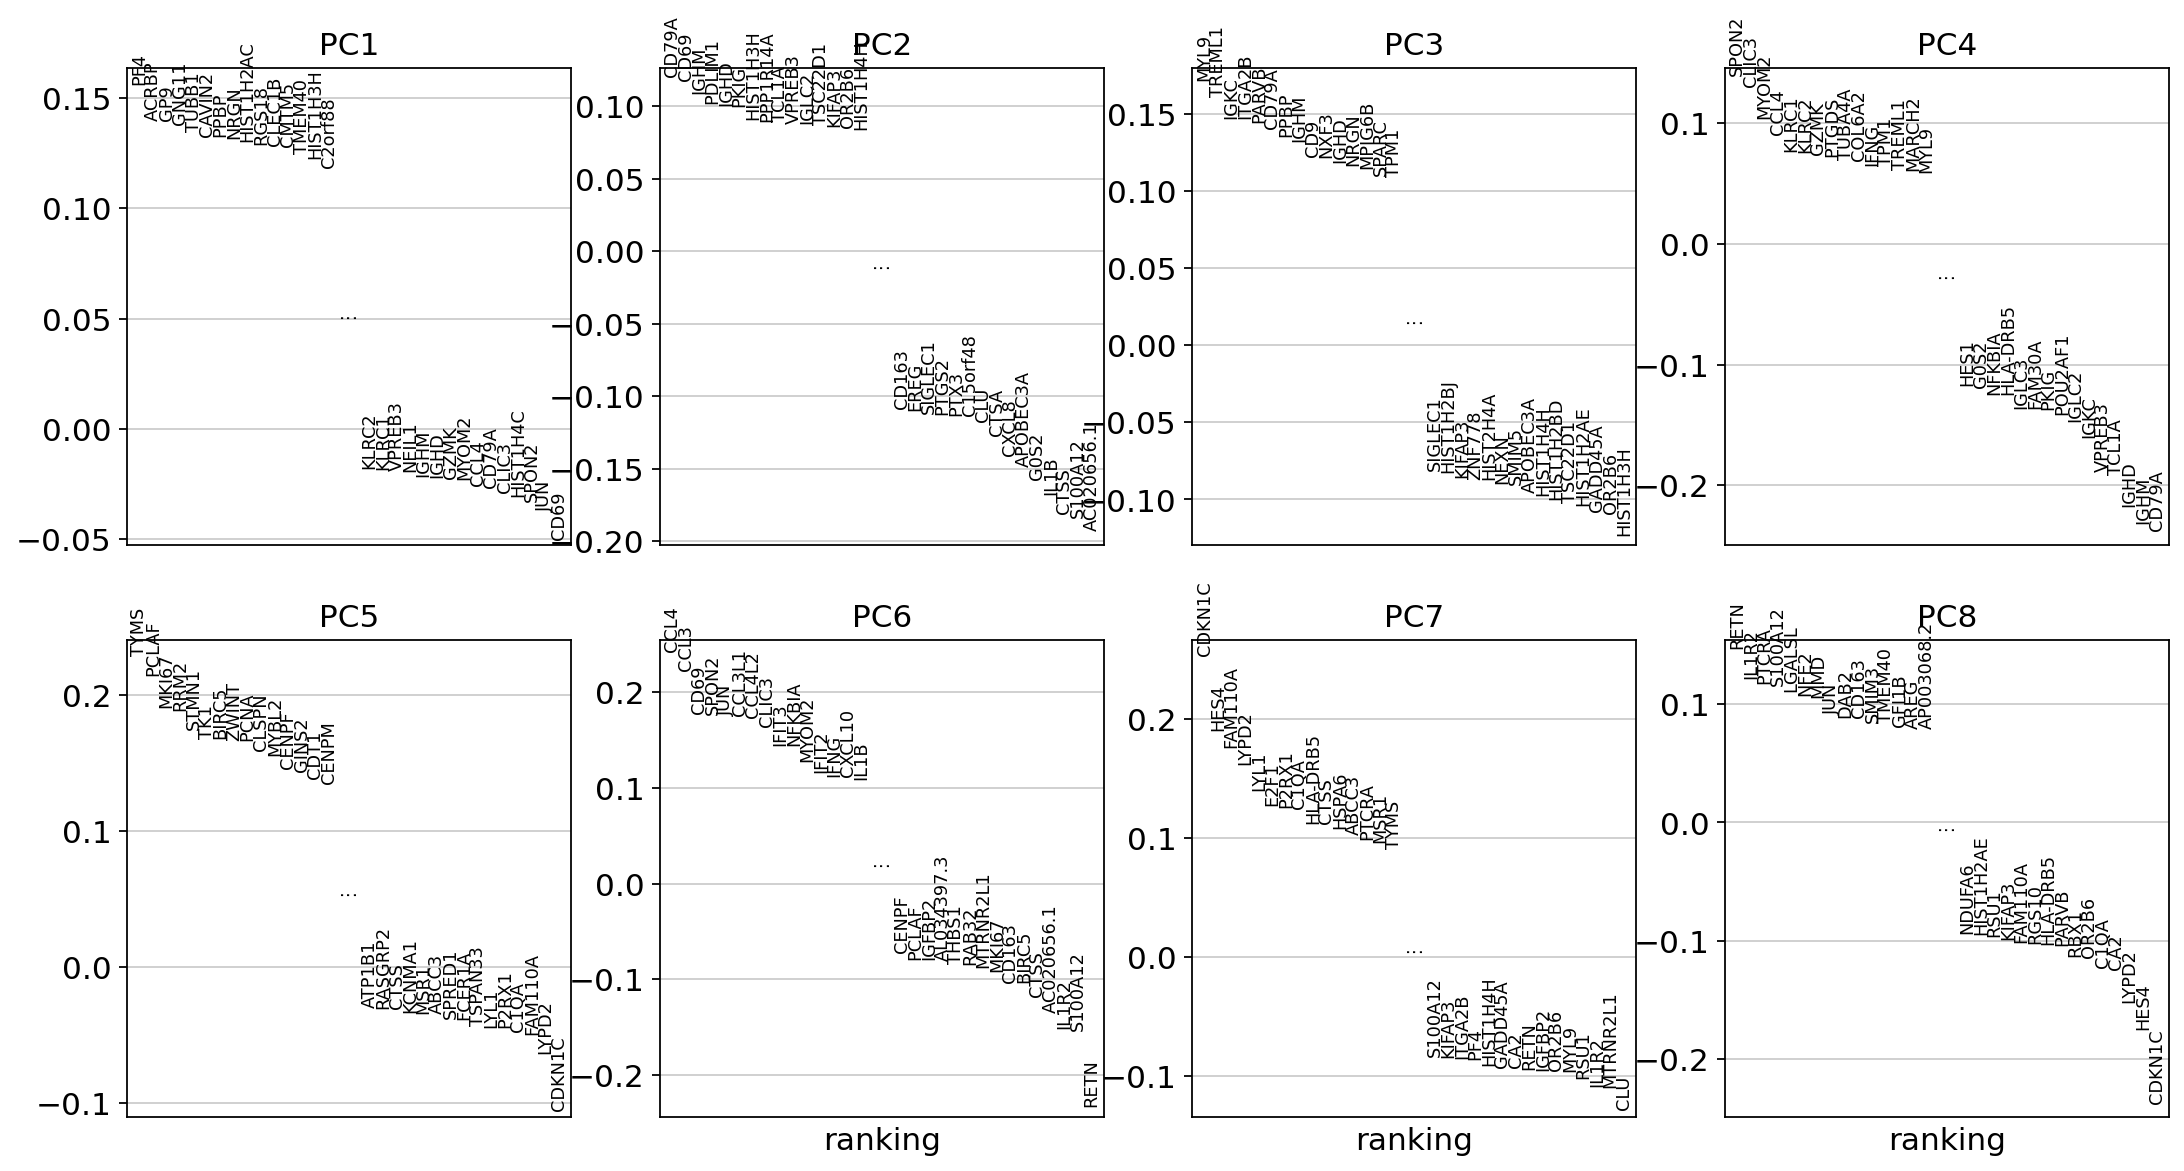

In [11]:
# to identify genes that contribute most to each PC, one can retrieve the loading matrix information
sc.pl.pca_loadings(adata, components=[1, 2, 3, 4, 5, 6, 7, 8])

In [15]:
# adata.obsm["X_pca"] is the embeddings
# adata.uns["pca"] is pc variance
# adata.varm['PCs'] is the loadings

genes = adata.var['gene_ids']

for pc in [1,2,3,4]:
    g = adata.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:10],o[-10:])).tolist()
    emb = adata.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    tempdata = adata[np.argsort(emb),]
    sc.pl.heatmap(tempdata, var_names = genes[sel].index.tolist(), groupby=None, 
                  swap_axes = True, use_raw=False)

TypeError: ignored

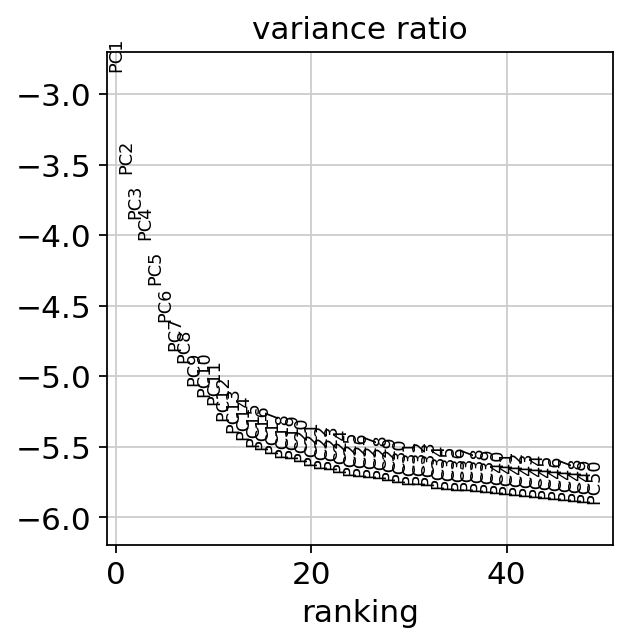

In [17]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)


In [18]:
# t-SNE
sc.tl.tsne(adata, n_pcs=30)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:56)


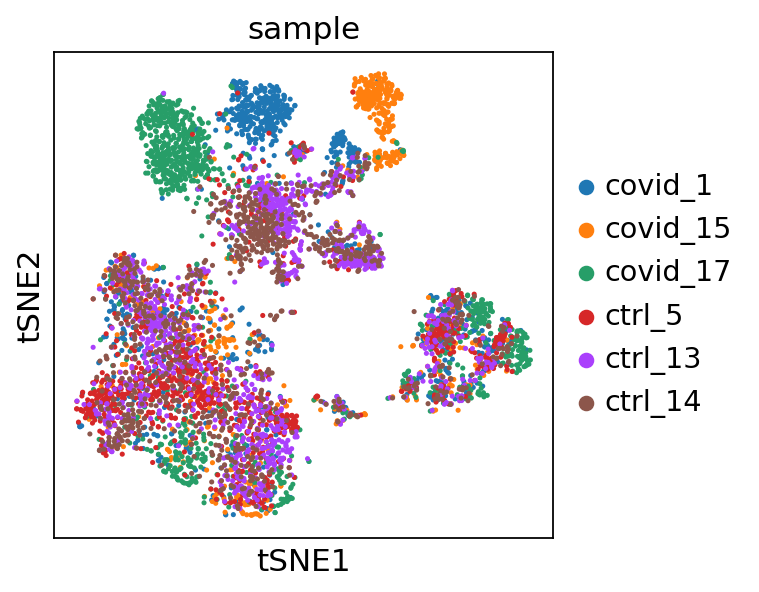

In [19]:
sc.pl.tsne(adata, color='sample')

In [20]:
# UMAP
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)

computing neighbors
    using 'X_pca' with n_pcs = 30


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)


In [21]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


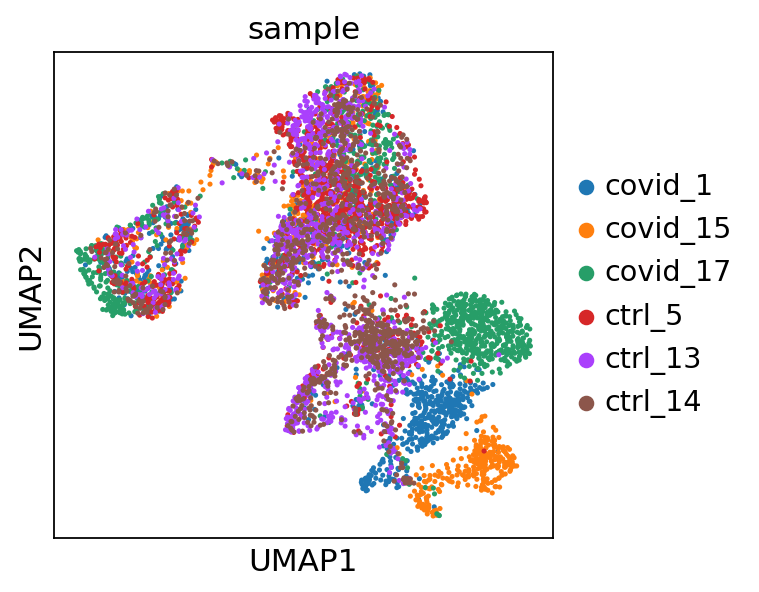

In [22]:
sc.pl.umap(adata, color='sample')

In [23]:
# plot some genes of interest
sc.pl.umap(adata, color=["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","CD14","LYZ","CST3","MS4A7","FCGR3A"])

Output hidden; open in https://colab.research.google.com to view.

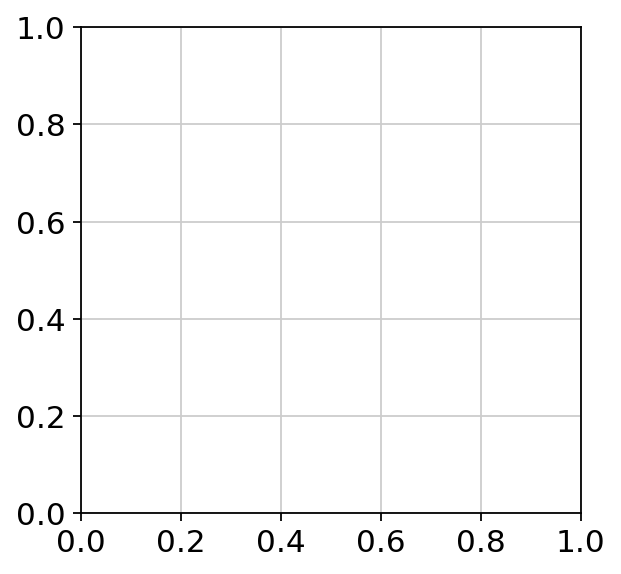

In [24]:
# default is to plot in the normalized and log-transformed data
# plot on the scaled and corrected data by using the use_raw=False
genes  = ["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","CD14","LYZ","CST3","MS4A7","FCGR3A"]
var_genes = adata.var.highly_variable
var_genes.index[var_genes]
varg = [x for x in genes if x in var_genes.index[var_genes]]
sc.pl.umap(adata, color=varg, use_raw=False)

In [25]:
adata.var.highly_variable

HES4          True
SMIM1         True
SLC25A34      True
AL035413.1    True
UBXN10-AS1    True
              ... 
BX537318.1    True
CBR3          True
KCNJ15        True
COL6A2        True
S100B         True
Name: highly_variable, Length: 610, dtype: bool